# Handling data in PyTorch
    
In this script, we see how to handle data in PyTorch using the `Dataset` and `Dataloader` objects. The focus is on an image and a speech dataset for convenience. We will adress text data specifically and the associated preprocessing in a future lab.

In [79]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import io
import torchaudio
import os
import fnmatch
from IPython.display import Audio, display
from matplotlib import pyplot as plt

## Image data

First, let's play around with images. We use the data provided in `data/image_corpus`, which is extracted from the [Pokemon dataset](https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types).

### Example

In [80]:
# Load an image from the corpus, convert it to a float tensor, and set the range of values in [0, 1]
image_path = '../datasets/image_corpus/pikachu.png'
x = io.read_image(image_path, mode=io.ImageReadMode.RGB)
x = x.float()
print(x.shape)
print(x.min(), x.max())
x = x/ x.max()
print(x.min(), x.max())

torch.Size([3, 120, 120])
tensor(0.) tensor(255.)
tensor(0.) tensor(1.)


In [81]:
# When loaded as RGB images, such a tensor has 3 channels (red, green, blue)
print(x.shape)

torch.Size([3, 120, 120])


In [82]:
# TO DO: Reshape x so that it's [height, width, channels] (useful for vizualization)
x = x.reshape(x.shape[1], x.shape[2], x.shape[0])
print(x.shape)

torch.Size([120, 120, 3])


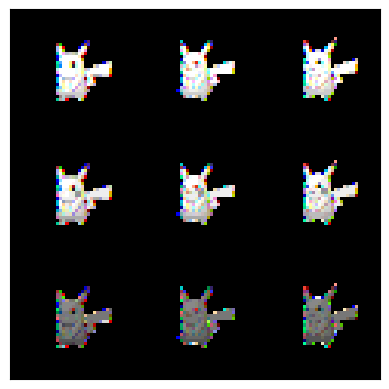

In [83]:
# Display the image
plt.figure()
plt.imshow(x)
plt.xticks([]), plt.yticks([])
plt.show()

In [84]:
# You can get the name of the pokemon by removing the folder path ('data/image_corpus/') and extension ('.png') from the image_path
name = image_path.replace('../datasets/image_corpus/', '').replace('.png', '')
print(name)

pikachu


### Dataset

We now create an image Dataset. It's a python class that allows to store and manipulate all the data instead of manually load and process each data sample (=image) independently.

A `Dataset` python class must consists of at least 3 methods:
- `__init__`, which initializes the object when instanciated.
- `__len__`, which returns the lenght (= number of samples) of the dataset.
- `__getitem__`, which allows to access a sample using it's index number.

Of course you can add as many methods as you want for preprocessing the data if needed.

**Note**: Python classes usually define and use some variables/data/tensors/dictionary etc. internally. These are called *attributes*, and should be defined in the `__init__` method with a specific structure (the name should start by `self.`, see below). This allows you to access these attributes in other methods, or once you instanciate the dataset.

In [85]:
class ImageDataset(Dataset):

    def __init__(self, image_dir):
        """Initialize the attributes of the object of the class."""
        self.image_dir = image_dir
        self.image_path_list = sorted(self._find_files(image_dir))

    def __len__(self):
        """Return the size of the dataset."""
        return len(self.image_path_list)

    def __getitem__(self, index):
        """Return a data sample (=one image) for a given index, along with the name of the corresponding pokemon."""
        
        # TO DO:
        # - get the image path corresponding to 'index' (use the list 'self.image_path_list')
        image = self.image_path_list[index]
        print(image)
        # - get the pokemon name
        name = image.replace('../datasets/image_corpus/', '').replace('.png', '')
        # - load the image into a tensor x
        x = io.read_image(image, mode=io.ImageReadMode.RGB)
        # - convert it to a float tensor
        float_tensor = x.float()
        # - normalize it so x ranges between 0 and 1
        x_norm = float_tensor/float_tensor.max()
        # - reshape it as [height, width, channels] (useful for vizualization)
        x_reshaped = x_norm.reshape(x_norm.shape[1], x_norm.shape[2], x_norm.shape[0])
        # - return the tensor x and the pokemon name
        return x_reshaped, name
    

    def _find_files(self, directory, pattern='*.png'):
        """Recursively find all files matching the pattern."""
        image_path_list = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                image_path_list.append(os.path.join(root, filename))
        return image_path_list


In [86]:
# We can initialize the dataset by providing the directory of the image corpus data
image_dir = '../datasets/image_corpus/'
dataset = ImageDataset(image_dir=image_dir)

# You can use the '_find_files' method to get the list of images paths
image_path_list = dataset._find_files(image_dir)

# Equivalently, since this list is stored as an inner attribute, you can access it directly:
image_path_list = dataset.image_path_list
# Display all file paths
for l in image_path_list:
    print(l)
print('Number of images in the list', len(image_path_list))

../datasets/image_corpus/abomasnow.png
../datasets/image_corpus/aegislash-blade.png
../datasets/image_corpus/alakazam.png
../datasets/image_corpus/ambipom.png
../datasets/image_corpus/arcanine.png
../datasets/image_corpus/arceus.png
../datasets/image_corpus/archeops.png
../datasets/image_corpus/armaldo.png
../datasets/image_corpus/aromatisse.png
../datasets/image_corpus/articuno.png
../datasets/image_corpus/aurorus.png
../datasets/image_corpus/avalugg.png
../datasets/image_corpus/barbaracle.png
../datasets/image_corpus/beedrill.png
../datasets/image_corpus/blastoise.png
../datasets/image_corpus/blaziken.png
../datasets/image_corpus/bouffalant.png
../datasets/image_corpus/braviary.png
../datasets/image_corpus/camerupt.png
../datasets/image_corpus/carracosta.png
../datasets/image_corpus/chandelure.png
../datasets/image_corpus/charizard.png
../datasets/image_corpus/chesnaught.png
../datasets/image_corpus/clawitzer.png
../datasets/image_corpus/cobalion.png
../datasets/image_corpus/cofagrig

In [87]:
# To get the length of the dataset, you can use 'len(dataset)', which calls the method '__len__'
print('Dataset length:', dataset.__len__())
print('Dataset length:', len(dataset))

Dataset length: 151
Dataset length: 151


In [88]:
# TO DO:
# - load the image with index '0' from the dataset (hint: you can use 'dataset[0]', which is the same as '__getitem__(index)')
first_image = dataset[0]
# - print its shape, display the pokemon's name, and plot the image
print('Image shape: ', first_image[0].shape)
print('Pokemon name: ', first_image[1])


../datasets/image_corpus/abomasnow.png
Image shape:  torch.Size([120, 120, 3])
Pokemon name:  abomasnow


### Dataloader

A `Dataset` object stores all the data, and it might be very large. In practice, when using deep neural networks, we want to divide it into small packs (or *minibatches*) of data, in order to feed the network and compute stochatstic gradient descent. To that end, we create a `Dataloader`: it's a python class which samples over the dataset (that's the *batch sampler*) and assembles the data and labels (using a *collate function*) to generate batches.

&nbsp;
<center><a href="https://twitter.com/i/status/1363494433715552259">
    <img src="https://pbs.twimg.com/ext_tw_video_thumb/1363493414361305099/pu/img/x_qwSxBU2l0o5Y2z.jpg" width="500"></a>
</center>
<center>
(click on the image above to check the animation)
</center>
&nbsp;

The good news is that there's a Pytorch function that does it automatically, so we don't need to bother with coding the batch sampler nor the collate function.

In [89]:
# Set the batch size (=number of samples/images in each batch) and create the dataloader
batch_size = 5
image_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

../datasets/image_corpus/druddigon.png
../datasets/image_corpus/kadabra.png
../datasets/image_corpus/regirock.png
../datasets/image_corpus/avalugg.png
../datasets/image_corpus/talonflame.png
torch.Size([5, 120, 120, 3])


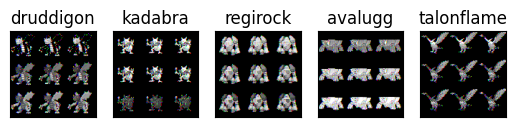

In [90]:
# Take one batch and print the shape of the image tensor
image_batch_data, image_batch_name = next(iter(image_dataloader))
print(image_batch_data.shape)

# Plot the images along with the corresponding names
plt.figure()
for ib in range(batch_size):
    plt.subplot(1, batch_size, ib+1)
    plt.imshow(image_batch_data[ib, :])
    plt.title(image_batch_name[ib])
    plt.xticks([]), plt.yticks([])
plt.show()

In [91]:
# The total number of batches can be access easily
print('Dataloader length (number of batches):', len(image_dataloader))

Dataloader length (number of batches): 31


In [92]:
# TO DO: iterate over the dataloader (use a for loop) and print the shape of each batch of image.
for i, data in enumerate(image_dataloader):
    print('Batch ', i, ' shape: ', data[0].shape)

../datasets/image_corpus/kyurem.png
../datasets/image_corpus/venusaur.png
../datasets/image_corpus/ferrothorn.png
../datasets/image_corpus/deoxys-normal.png
../datasets/image_corpus/aromatisse.png
Batch  0  shape:  torch.Size([5, 120, 120, 3])
../datasets/image_corpus/flygon.png
../datasets/image_corpus/ho-oh.png
../datasets/image_corpus/samurott.png
../datasets/image_corpus/feraligatr.png
../datasets/image_corpus/aegislash-blade.png
Batch  1  shape:  torch.Size([5, 120, 120, 3])
../datasets/image_corpus/hariyama.png
../datasets/image_corpus/arceus.png
../datasets/image_corpus/tyrantrum.png
../datasets/image_corpus/exploud.png
../datasets/image_corpus/mandibuzz.png
Batch  2  shape:  torch.Size([5, 120, 120, 3])
../datasets/image_corpus/rapidash.png
../datasets/image_corpus/zoroark.png
../datasets/image_corpus/arcanine.png
../datasets/image_corpus/aurorus.png
../datasets/image_corpus/entei.png
Batch  3  shape:  torch.Size([5, 120, 120, 3])
../datasets/image_corpus/crawdaunt.png
../datas

You should remark from the code above that the last batch has a different size than the others. This is because in the dataset there are 151 images and the `batch_size` is 5: therefore there are 30 batches with 5 images, and the last batch contains the remaining 1 image.

To avoid this (which might be useful in some applications where you need to process each batch with the same size), you can get ridd of the last batch with a different size. To do so, simply use the `drop_last=True` option when defining the dataloader.

In [93]:
# TO DO: Define the dataloader while removing the last batch, and print the length of the new dataloader.
data_loader_no_last_batch = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
print('Dataloader length (number of batches):', len(data_loader_no_last_batch))

Dataloader length (number of batches): 30


../datasets/image_corpus/articuno.png
../datasets/image_corpus/conkeldurr.png
../datasets/image_corpus/mandibuzz.png
../datasets/image_corpus/simipour.png
../datasets/image_corpus/avalugg.png


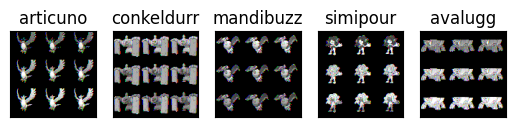

../datasets/image_corpus/arcanine.png
../datasets/image_corpus/raikou.png
../datasets/image_corpus/bouffalant.png
../datasets/image_corpus/malamar.png
../datasets/image_corpus/hariyama.png


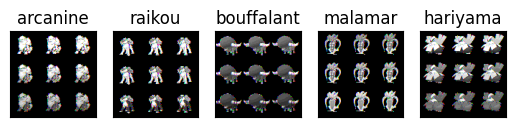

../datasets/image_corpus/lilligant.png
../datasets/image_corpus/electabuzz.png
../datasets/image_corpus/blaziken.png
../datasets/image_corpus/hydreigon.png
../datasets/image_corpus/gyarados.png


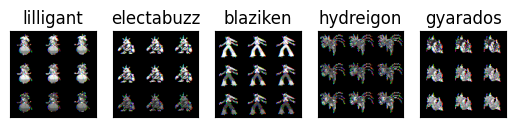

../datasets/image_corpus/ludicolo.png
../datasets/image_corpus/lugia.png
../datasets/image_corpus/ferrothorn.png
../datasets/image_corpus/reuniclus.png
../datasets/image_corpus/florges.png


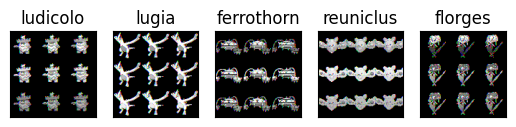

../datasets/image_corpus/druddigon.png
../datasets/image_corpus/exploud.png
../datasets/image_corpus/abomasnow.png
../datasets/image_corpus/mothim.png
../datasets/image_corpus/alakazam.png


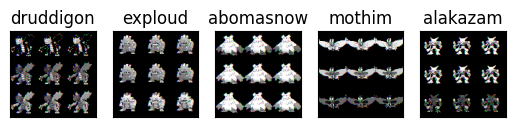

../datasets/image_corpus/stoutland.png
../datasets/image_corpus/diggersby.png
../datasets/image_corpus/suicune.png
../datasets/image_corpus/dragalge.png
../datasets/image_corpus/sigilyph.png


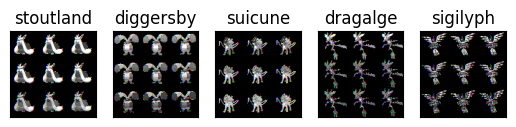

../datasets/image_corpus/golurk.png
../datasets/image_corpus/gigalith.png
../datasets/image_corpus/infernape.png
../datasets/image_corpus/archeops.png
../datasets/image_corpus/arceus.png


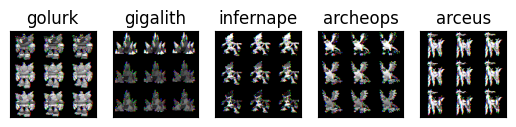

../datasets/image_corpus/chesnaught.png
../datasets/image_corpus/flygon.png
../datasets/image_corpus/zygarde-50.png
../datasets/image_corpus/electivire.png
../datasets/image_corpus/palkia.png


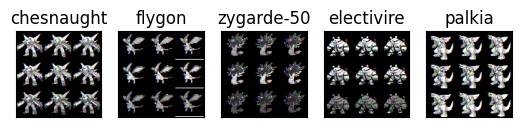

../datasets/image_corpus/emboar.png
../datasets/image_corpus/rapidash.png
../datasets/image_corpus/nidoqueen.png
../datasets/image_corpus/chandelure.png
../datasets/image_corpus/drapion.png


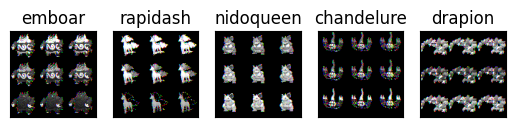

../datasets/image_corpus/loudred.png
../datasets/image_corpus/swampert.png
../datasets/image_corpus/aurorus.png
../datasets/image_corpus/rayquaza.png
../datasets/image_corpus/darmanitan-standard.png


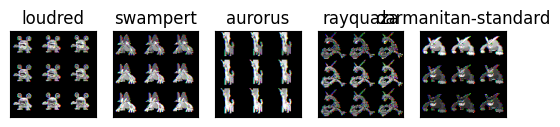

../datasets/image_corpus/scizor.png
../datasets/image_corpus/blastoise.png
../datasets/image_corpus/xerneas.png
../datasets/image_corpus/torterra.png
../datasets/image_corpus/feraligatr.png


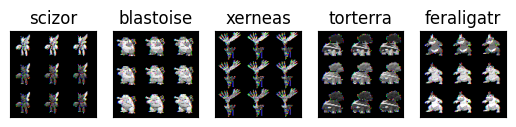

../datasets/image_corpus/virizion.png
../datasets/image_corpus/kyurem.png
../datasets/image_corpus/mamoswine.png
../datasets/image_corpus/heatmor.png
../datasets/image_corpus/magneton.png


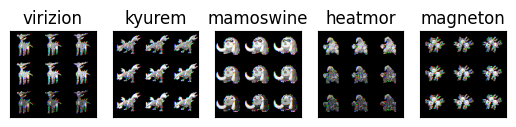

../datasets/image_corpus/haxorus.png
../datasets/image_corpus/samurott.png
../datasets/image_corpus/salamence.png
../datasets/image_corpus/tyranitar.png
../datasets/image_corpus/kangaskhan.png


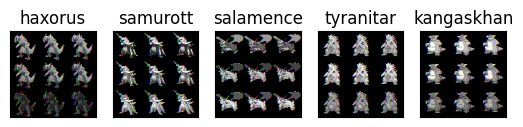

../datasets/image_corpus/entei.png
../datasets/image_corpus/nidoking.png
../datasets/image_corpus/hawlucha.png
../datasets/image_corpus/escavalier.png
../datasets/image_corpus/regigigas.png


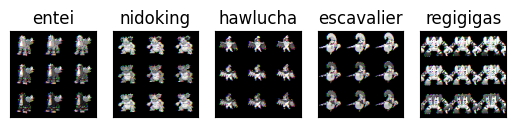

../datasets/image_corpus/volcanion.png
../datasets/image_corpus/zekrom.png
../datasets/image_corpus/ninetales.png
../datasets/image_corpus/crustle.png
../datasets/image_corpus/tyrantrum.png


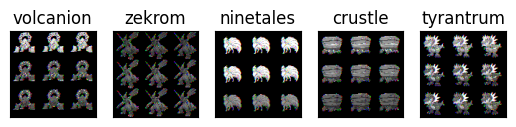

../datasets/image_corpus/ambipom.png
../datasets/image_corpus/venusaur.png
../datasets/image_corpus/aegislash-blade.png
../datasets/image_corpus/terrakion.png
../datasets/image_corpus/deoxys-normal.png


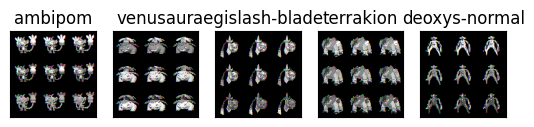

../datasets/image_corpus/regice.png
../datasets/image_corpus/krookodile.png
../datasets/image_corpus/clawitzer.png
../datasets/image_corpus/talonflame.png
../datasets/image_corpus/groudon.png


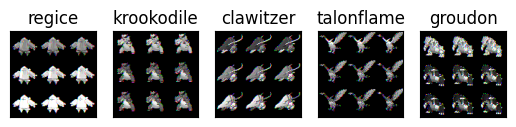

../datasets/image_corpus/dialga.png
../datasets/image_corpus/scolipede.png
../datasets/image_corpus/crawdaunt.png
../datasets/image_corpus/cofagrigus.png
../datasets/image_corpus/shiftry.png


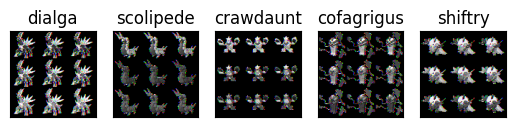

../datasets/image_corpus/barbaracle.png
../datasets/image_corpus/delphox.png
../datasets/image_corpus/metagross.png
../datasets/image_corpus/seismitoad.png
../datasets/image_corpus/genesect.png


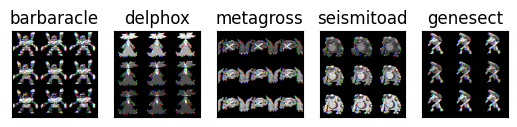

../datasets/image_corpus/armaldo.png
../datasets/image_corpus/sceptile.png
../datasets/image_corpus/milotic.png
../datasets/image_corpus/pidgeot.png
../datasets/image_corpus/zapdos.png


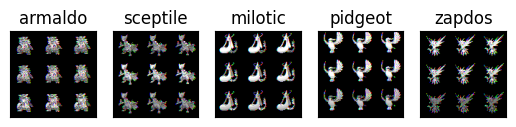

../datasets/image_corpus/cobalion.png
../datasets/image_corpus/metang.png
../datasets/image_corpus/moltres.png
../datasets/image_corpus/tangrowth.png
../datasets/image_corpus/empoleon.png


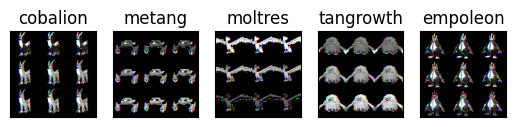

../datasets/image_corpus/reshiram.png
../datasets/image_corpus/serperior.png
../datasets/image_corpus/machoke.png
../datasets/image_corpus/eelektross.png
../datasets/image_corpus/aromatisse.png


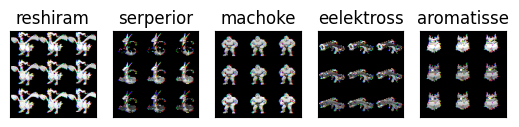

../datasets/image_corpus/trevenant.png
../datasets/image_corpus/throh.png
../datasets/image_corpus/greninja.png
../datasets/image_corpus/tornadus-incarnate.png
../datasets/image_corpus/staraptor.png


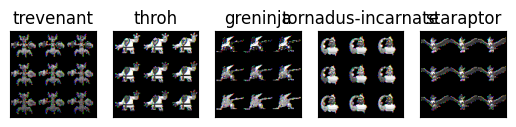

../datasets/image_corpus/klinklang.png
../datasets/image_corpus/vivillon.png
../datasets/image_corpus/charizard.png
../datasets/image_corpus/garchomp.png
../datasets/image_corpus/gliscor.png


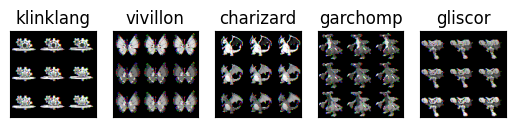

../datasets/image_corpus/gogoat.png
../datasets/image_corpus/heatran.png
../datasets/image_corpus/luxray.png
../datasets/image_corpus/doublade.png
../datasets/image_corpus/wailord.png


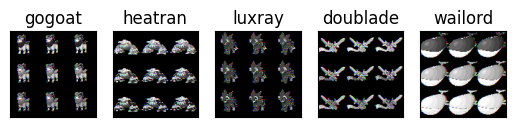

../datasets/image_corpus/pyroar.png
../datasets/image_corpus/regirock.png
../datasets/image_corpus/yveltal.png
../datasets/image_corpus/noivern.png
../datasets/image_corpus/slowbro.png


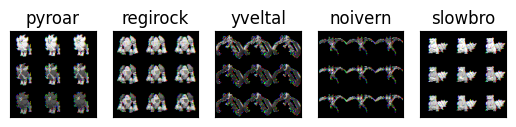

../datasets/image_corpus/magmar.png
../datasets/image_corpus/beedrill.png
../datasets/image_corpus/ho-oh.png
../datasets/image_corpus/carracosta.png
../datasets/image_corpus/giratina-altered.png


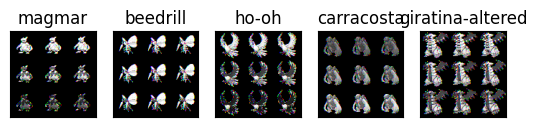

../datasets/image_corpus/machamp.png
../datasets/image_corpus/pikachu.png
../datasets/image_corpus/ursaring.png
../datasets/image_corpus/volcarona.png
../datasets/image_corpus/camerupt.png


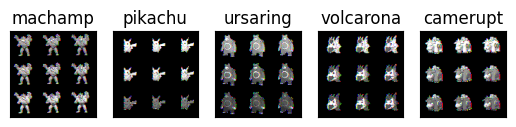

../datasets/image_corpus/zoroark.png
../datasets/image_corpus/garbodor.png
../datasets/image_corpus/kadabra.png
../datasets/image_corpus/cryogonal.png
../datasets/image_corpus/dusknoir.png


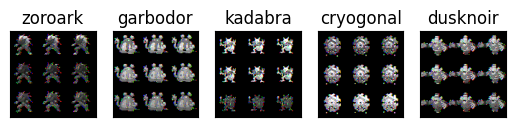

../datasets/image_corpus/exeggutor.png
../datasets/image_corpus/fearow.png
../datasets/image_corpus/rhydon.png
../datasets/image_corpus/rhyperior.png
../datasets/image_corpus/braviary.png


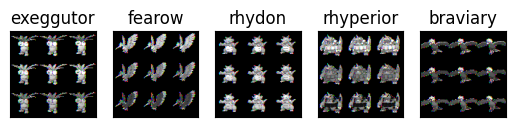

In [94]:
# TO DO: iterate over the dataloader and display all images with the name of the pokemon as title
for i, data in enumerate(data_loader_no_last_batch):
    plt.figure()
    for ib in range(batch_size):
        plt.subplot(1, batch_size, ib+1)
        plt.imshow(data[0][ib, :])
        plt.title(data[1][ib])
        plt.xticks([]), plt.yticks([])
    plt.show()


## Speech data

Let's now work with speech data. The audio signals are provided in the `data/audio_corpus/` folder.

### Example

In [95]:
# Load an audio file using the torchaudio.load() function
x, sampling_frequency = torchaudio.load('../datasets/audio_corpus/arctic_a0001.wav')

# Print the shape of x: it should be [n_channels, n_samples], so since it's mono (n_channels=1), you can squeeze it
print(x.shape)
x = x.squeeze()
print(x.shape)

torch.Size([1, 53680])
torch.Size([53680])


In [96]:
# Print the sampling frequency
print('Sampling frequency:', sampling_frequency, 'Hz')
print('length of x:', len(x))
# The duration of the signal (in seconds) can be computed as follows:
duration = len(x) / sampling_frequency
print('Duration:', duration, 's')

# We can use the 'display(Audio())' function to have a graphical audio reader
display(Audio(data=x, rate=sampling_frequency))

Sampling frequency: 16000 Hz
length of x: 53680
Duration: 3.355 s


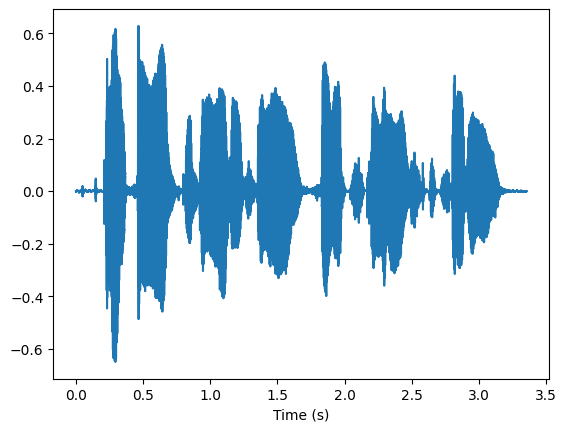

In [97]:
# We can plot the audio waveform as a function of time (in seconds)
time_indices = torch.arange(len(x)) / sampling_frequency
plt.figure()
plt.plot(time_indices, x)
plt.xlabel('Time (s)')
plt.show()

Max length: 32000


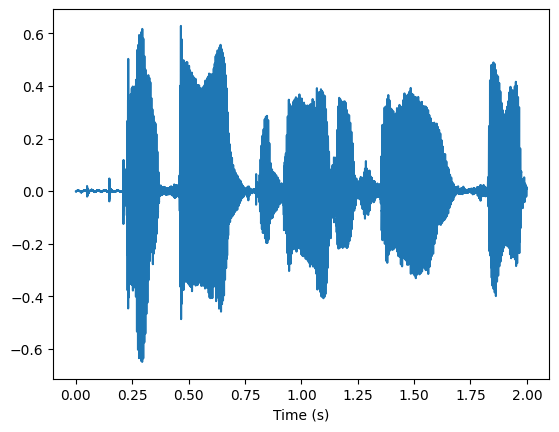

In [98]:
# Define the maximum duration (in seconds and in number of samples)
max_dur = 2.0
max_len = int(max_dur * sampling_frequency)
print('Max length:', max_len)

# TO DO: Set the signal x at this maximum duration defined above
# - if the length of x is larger than max_len, then crop it
if len(x) > max_len:
    x = x[:max_len]
# - if the length of x is smaller than max_len, then add zeros (use cat) accordingly at the end of the signal
elif len(x) < max_len:
    x = torch.cat((x, torch.zeros(max_len - len(x))))
else:
    pass
# Plot the result
plt.figure()
plt.plot(torch.arange(len(x)) / sampling_frequency, x)
plt.xlabel('Time (s)')
plt.show()




### Dataset and dataloader

Now, we can create the speech Dataset.

In [99]:
class SpeechDataset(Dataset):

    def __init__(self, audio_dir, max_dur):
        """Initialize the attributes of the object of the class."""
        self.audio_dir = audio_dir
        self.max_dur = max_dur
        self.audio_path_list = sorted(self._find_files(audio_dir))

    def __len__(self):
        """Return the size of the dataset."""
        return len(self.audio_path_list)

    def __getitem__(self, index):
        """Return a data sample (= speech signal) for a given index."""
        
        # TO DO:
        # - get the audio path corresponding to 'index' (use the list 'self.audio_path_list')
        audio = self.audio_path_list[index]
        print("index: ", audio)
        # - get the name of the audio (as for images, use '.replace()')
        name = audio.replace('../datasets/audio_corpus/', '').replace('.wav', '')
        # - load the speech signal into a tensor x
        x, sampling_frequency = torchaudio.load(audio)
        print(x.shape)
        # - squeeze x to remove the useless dimension
        x = x.squeeze()
        # - use a method (which you have to code) to set the length of x at a given duration 'self.max_dur'
        x = self._set_duration(x, self.max_dur)
        # - return x and the name of the audio
        return x, name
    
    
    def _find_files(self, directory, pattern='*.wav'):
        """Recursively find all files matching the pattern."""
        audio_path_list = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                audio_path_list.append(os.path.join(root, filename))
        return audio_path_list
    
    def _set_duration(self, x, max_dur, sampling_frequency=16000):
        """Set the input signal at a specified duration."""
        # TO DO: code it
        max_len = int(max_dur * sampling_frequency)
        if len(x) > max_len:
            x = x[:max_len]
        # - if the length of x is smaller than max_len, then add zeros (use cat) accordingly at the end of the signal
        elif len(x) < max_len:
            x = torch.cat((x, torch.zeros(max_len - len(x))))
        return x
        

In [100]:
# TO DO: Instanciate the dataset (specify the audio directory and a maximum duration of 2 seconds),
audio_dir = '../datasets/audio_corpus/'
max_dur = 2.0
dataset = SpeechDataset(audio_dir, max_dur)
# Print the dataset's length, and the list of files
print('Dataset length:', len(dataset))
print('List of files:', dataset.audio_path_list)  


Dataset length: 15
List of files: ['../datasets/audio_corpus/arctic_a0001.wav', '../datasets/audio_corpus/arctic_a0002.wav', '../datasets/audio_corpus/arctic_a0003.wav', '../datasets/audio_corpus/arctic_a0004.wav', '../datasets/audio_corpus/arctic_a0005.wav', '../datasets/audio_corpus/arctic_a0006.wav', '../datasets/audio_corpus/arctic_a0007.wav', '../datasets/audio_corpus/arctic_a0008.wav', '../datasets/audio_corpus/arctic_a0009.wav', '../datasets/audio_corpus/arctic_a0010.wav', '../datasets/audio_corpus/arctic_a0011.wav', '../datasets/audio_corpus/arctic_a0012.wav', '../datasets/audio_corpus/arctic_a0013.wav', '../datasets/audio_corpus/arctic_a0014.wav', '../datasets/audio_corpus/arctic_a0015.wav']


index:  ../datasets/audio_corpus/arctic_a0001.wav
torch.Size([1, 53680])
Speech signal shape: torch.Size([32000])
Speech signal name: arctic_a0001


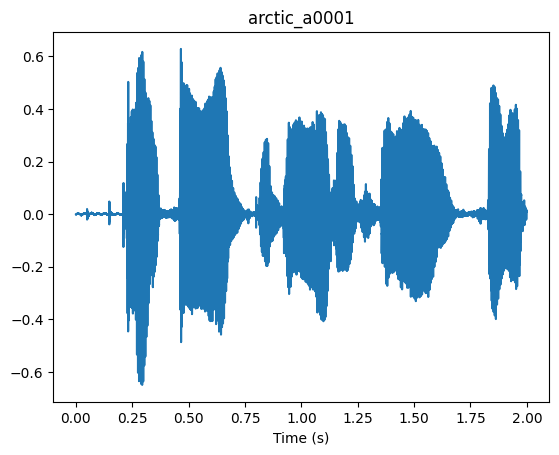

In [101]:
# TO DO: load the speech signal with index '0' from the dataset (and its name), print its shape,
speech_signal = dataset[0]
print('Speech signal shape:', speech_signal[0].shape)
print('Speech signal name:', speech_signal[1])
# plot the signal (with the name as title) and the graphical audio reader
plt.figure()
plt.plot(torch.arange(len(speech_signal[0])) / sampling_frequency, speech_signal[0])
plt.xlabel('Time (s)')
plt.title(speech_signal[1])
plt.show()

index:  ../datasets/audio_corpus/arctic_a0002.wav
torch.Size([1, 60080])
index:  ../datasets/audio_corpus/arctic_a0015.wav
torch.Size([1, 30001])
index:  ../datasets/audio_corpus/arctic_a0014.wav
torch.Size([1, 46321])


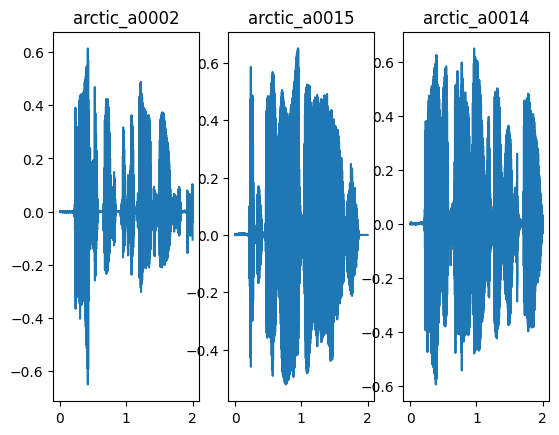

index:  ../datasets/audio_corpus/arctic_a0012.wav
torch.Size([1, 45360])
index:  ../datasets/audio_corpus/arctic_a0007.wav
torch.Size([1, 48081])
index:  ../datasets/audio_corpus/arctic_a0008.wav
torch.Size([1, 36560])


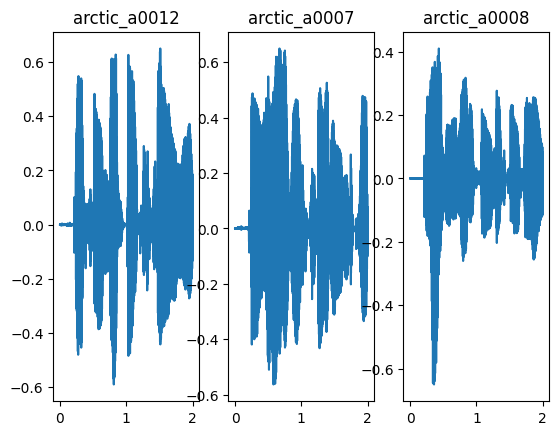

index:  ../datasets/audio_corpus/arctic_a0013.wav
torch.Size([1, 56401])
index:  ../datasets/audio_corpus/arctic_a0001.wav
torch.Size([1, 53680])
index:  ../datasets/audio_corpus/arctic_a0003.wav
torch.Size([1, 51281])


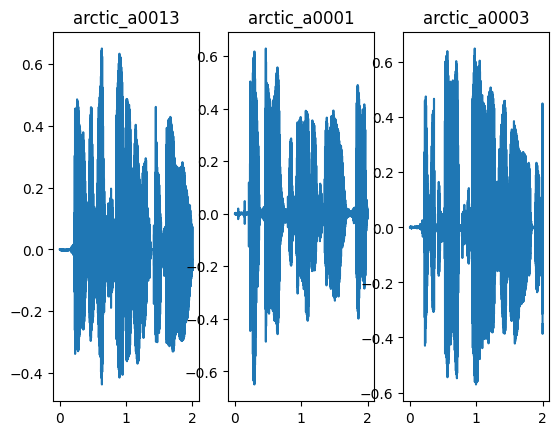

index:  ../datasets/audio_corpus/arctic_a0009.wav
torch.Size([1, 49520])
index:  ../datasets/audio_corpus/arctic_a0011.wav
torch.Size([1, 48881])
index:  ../datasets/audio_corpus/arctic_a0005.wav
torch.Size([1, 23761])


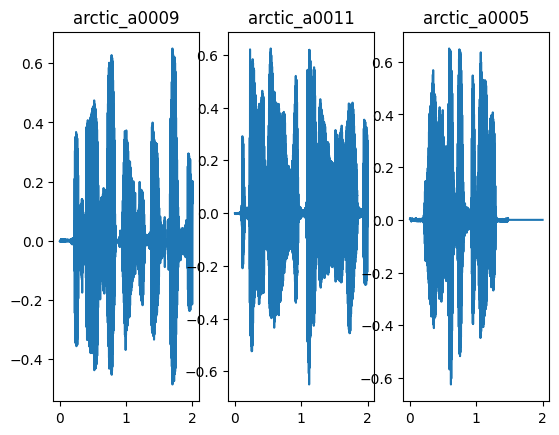

index:  ../datasets/audio_corpus/arctic_a0004.wav
torch.Size([1, 40081])
index:  ../datasets/audio_corpus/arctic_a0006.wav
torch.Size([1, 47441])
index:  ../datasets/audio_corpus/arctic_a0010.wav
torch.Size([1, 48241])


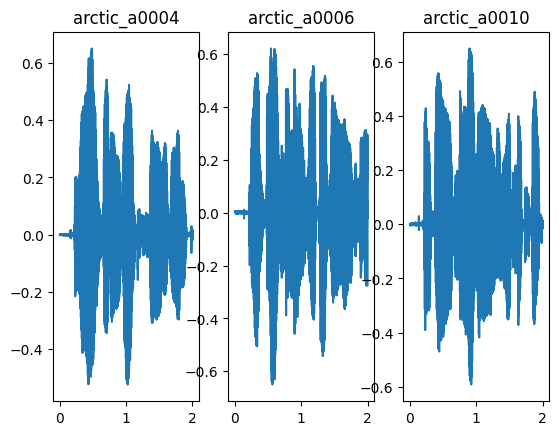

In [102]:
# TO DO: create a dataloader (batch size of 3), iterate over the dataloader and plot all the signals with name as title
batch_size = 3
audio_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for i, data in enumerate(audio_dataloader):
    plt.figure()
    for ib in range(batch_size):
        plt.subplot(1, batch_size, ib+1)
        plt.plot(torch.arange(len(data[0][ib])) / sampling_frequency, data[0][ib])
        plt.title(data[1][ib])
    plt.show()